# Data Science Capstone 3

## ImageClassifier Real vs Fake

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import os
import glob
import pickle

In [3]:
import sys

In [4]:
print(sys.version)

3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]


In [5]:
#!{sys.executable} -m pip install tensorflow==2.19.0 tensorflow-text==2.19.0 keras==3.5.0 tf-keras -U

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [7]:
# Remember, to access keras modules, call tf.keras

In [8]:
print('TensorFlow Version: ', tf.__version__)
print('Keras Version ', tf.keras.__version__)

TensorFlow Version:  2.20.0
Keras Version  3.11.3


## Preprocessing

Folder structure of the modified data:
- train_128
    - fake
    - real
- test_128
    - fake
    - real
- train_224
    - fake
    - real
- test_224
    - fake
    - real

In [9]:
train_128 = tf.keras.utils.image_dataset_from_directory(
    'modified_data/train_128',
    validation_split=0.2,
    subset='training',
    seed=30,
    image_size=(128, 128),
    batch_size=32,
    label_mode='binary',
    shuffle=True
)
val_128 = tf.keras.utils.image_dataset_from_directory(
    'modified_data/train_128',
    validation_split=0.2,
    subset='validation',
    seed=30,
    image_size=(128, 128),
    batch_size=32,
    label_mode='binary',
    shuffle=True
)
test_128 = tf.keras.utils.image_dataset_from_directory(
    'modified_data/test_128',
    seed=30,
    image_size=(128, 128),
    batch_size=32,
    label_mode='binary',
    shuffle=False
)

Found 48000 files belonging to 2 classes.
Using 38400 files for training.
Found 48000 files belonging to 2 classes.
Using 9600 files for validation.
Found 12000 files belonging to 2 classes.


In [10]:
train_128.element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [11]:
val_128.element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [12]:
test_128.element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [13]:
train_224 = tf.keras.utils.image_dataset_from_directory(
    'modified_data/train_224',
    validation_split=0.2,
    subset='training',
    seed=30,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary',
    shuffle=True
)
val_224 = tf.keras.utils.image_dataset_from_directory(
    'modified_data/train_224',
    validation_split=0.2,
    subset='validation',
    seed=30,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary',
    shuffle=True
)
test_224 = tf.keras.utils.image_dataset_from_directory(
    'modified_data/test_224',
    seed=30,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary',
    shuffle=False
)

Found 6906 files belonging to 2 classes.
Using 5525 files for training.
Found 6906 files belonging to 2 classes.
Using 1381 files for validation.
Found 2164 files belonging to 2 classes.


In [14]:
train_224.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [15]:
val_224.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [16]:
test_224.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [17]:
for images, labels in train_128.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Image dtype:", images.dtype)
    print("Label dtype:", labels.dtype)

Images shape: (32, 128, 128, 3)
Labels shape: (32, 1)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'float32'>


In [18]:
num_batches = tf.data.experimental.cardinality(train_128).numpy()
print("Number of batches:", num_batches)
print("Approx. total samples:", num_batches * 32)

Number of batches: 1200
Approx. total samples: 38400


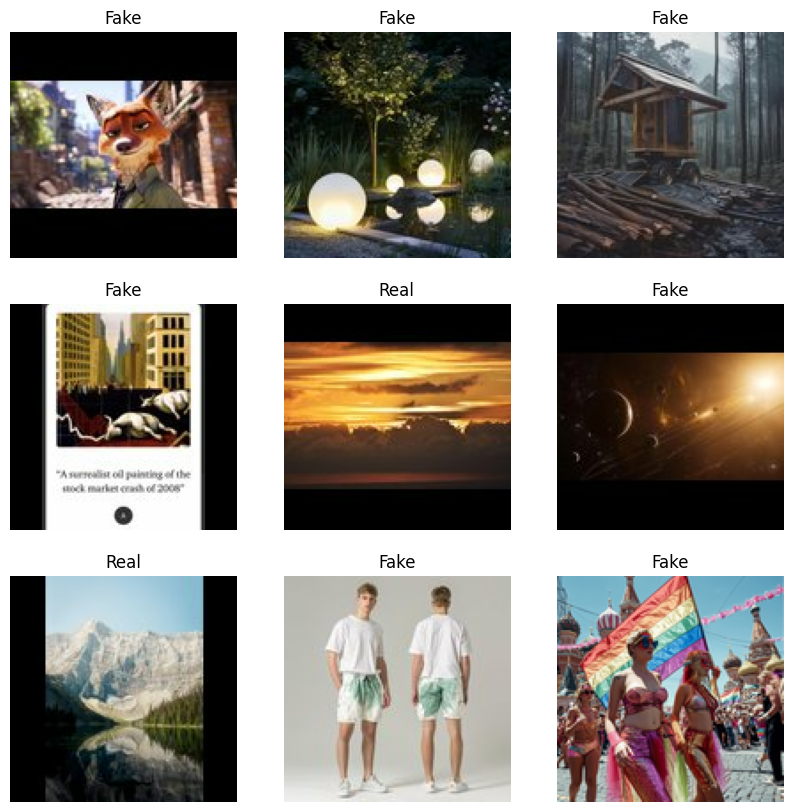

In [19]:
for images, labels in train_128.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Real" if labels[i] == 1 else "Fake")
        plt.axis("off")

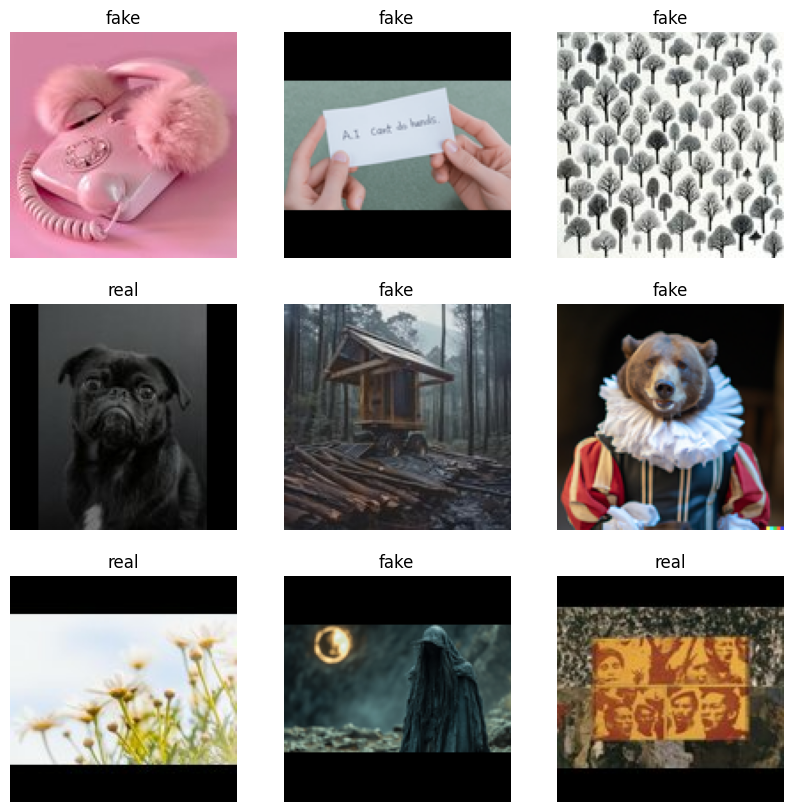

In [20]:
class_names = train_128.class_names

for images, labels in train_128.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = class_names[int(labels[i])]
        plt.title(label)
        plt.axis("off")

In [21]:
print(class_names)

['fake', 'real']


Since the datasets above are tf.data.Dataset, splitting into X and y is not required, meaning it straight to the modeling section.

## Modeling

### Models to consider:
- Resnet-50 (microsoft)
- vgg-16
- mobilenet (google)
- alexnet

Lets begin by first building a model from scratch with tensorflow.keras

In [22]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential

### Convolutional Neural Network (128x128)

In [21]:
model_128 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model_128.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [23]:
model_128.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model_128.fit(train_128, validation_data=val_128, epochs=10, batch_size=32)

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 519s 429ms/step - accuracy: 0.8542 - loss: 1.2541 - val_accuracy: 0.8884 - val_loss: 0.3185
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 334s 278ms/step - accuracy: 0.8882 - loss: 0.3168 - val_accuracy: 0.8915 - val_loss: 0.3104
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 329s 274ms/step - accuracy: 0.8971 - loss: 0.2983 - val_accuracy: 0.8969 - val_loss: 0.3100
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 400s 334ms/step - accuracy: 0.9004 - loss: 0.2849 - val_accuracy: 0.9032 - val_loss: 0.2870
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 324s 270ms/step - accuracy: 0.9049 - loss: 0.2738 - val_accuracy: 0.9000 - val_loss: 0.2981
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 413s 344ms/step - accuracy: 0.9105 - loss: 0.2579 - val_accuracy: 0.9015 - val_loss: 0.2989
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 360s 300ms/step - accuracy: 0.9116 - loss: 0.2512 - val_accuracy: 0.8991 - val_loss: 0.3192
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 333s 277ms/step - ac

In [25]:
val_loss, val_accuracy = model_128.evaluate(val_128, batch_size=32)

300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.8967 - loss: 0.3664


In [26]:
history_128 = history.history

In [27]:
history_128

{'accuracy': [0.8541927337646484,
  0.8882291913032532,
  0.897057294845581,
  0.9003645777702332,
  0.904869794845581,
  0.9105468988418579,
  0.9115625023841858,
  0.9138020873069763,
  0.9180729389190674,
  0.9217708110809326],
 'loss': [1.254108190536499,
  0.316846638917923,
  0.29825934767723083,
  0.28493332862854004,
  0.27377745509147644,
  0.25792747735977173,
  0.25120624899864197,
  0.2462921440601349,
  0.23481178283691406,
  0.22435641288757324],
 'val_accuracy': [0.8884375095367432,
  0.8914583325386047,
  0.8968750238418579,
  0.9032291769981384,
  0.8999999761581421,
  0.9014583230018616,
  0.8990625143051147,
  0.8886458277702332,
  0.8977083563804626,
  0.8966666460037231],
 'val_loss': [0.3184768855571747,
  0.31039318442344666,
  0.3099702298641205,
  0.28701770305633545,
  0.2981196343898773,
  0.29894161224365234,
  0.3191598653793335,
  0.38505271077156067,
  0.3240147531032562,
  0.3663763105869293]}

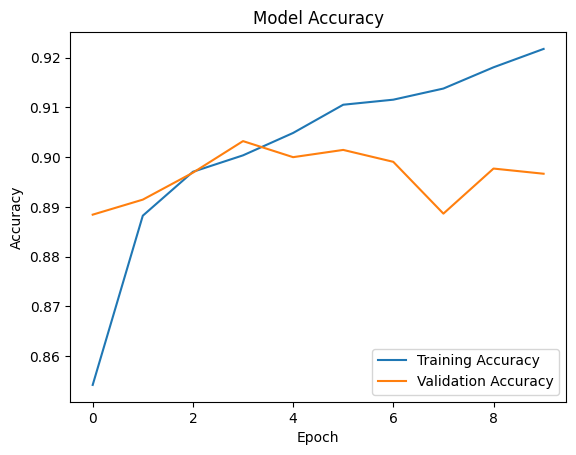

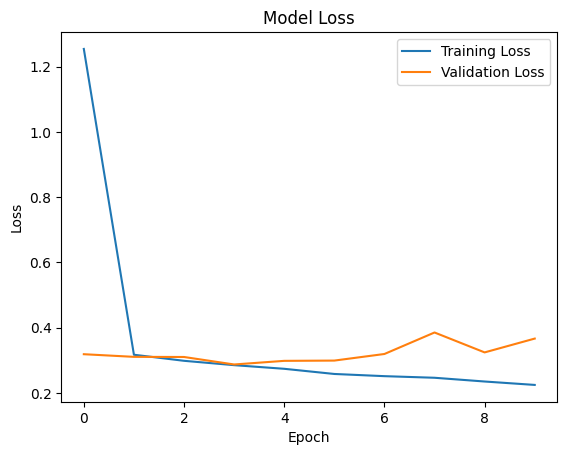

In [28]:
plt.plot(history_128['accuracy'], label='Training Accuracy')
plt.plot(history_128['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_128['loss'], label='Training Loss')
plt.plot(history_128['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [29]:
pred_128 = model_128.predict(test_128, batch_size=32)

375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step


In [30]:
test_loss, test_accuracy = model_128.evaluate(test_128, batch_size=32)

375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9044 - loss: 0.3502


### Convolutional Neural Network (224x224)

In [31]:
model_224 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(224, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [32]:
model_224.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [33]:
model_224.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 224)                 │      41,804,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,823,617 (159.54 MB)

 Trainable params: 41,823,617 (159.54 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model_224.fit(train_224, validation_data=val_224, epochs=10, batch_size=32)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8005 - loss: 22.3811 - val_accuracy: 0.8682 - val_loss: 0.3993
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8849 - loss: 0.3498 - val_accuracy: 0.8812 - val_loss: 0.3497
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.9059 - loss: 0.2753 - val_accuracy: 0.8747 - val_loss: 0.3715
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.9294 - loss: 0.2085 - val_accuracy: 0.8733 - val_loss: 0.4545
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9481 - loss: 0.1627 - val_accuracy: 0.8610 - val_loss: 0.5300
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9584 - loss: 0.1281 - val_accuracy: 0.8697 - val_loss: 0.6332
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9656 - loss: 0.1203 - val_accuracy: 0.8458 - val_loss: 0.7083
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9555 - loss: 0.1437 - val_acc

In [35]:
val_loss, val_accuracy = model_224.evaluate(val_224, batch_size=32)

44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.8646 - loss: 0.7858


In [36]:
history_224 = history.history

In [37]:
history_224

{'accuracy': [0.8005430102348328,
  0.8848868608474731,
  0.9058823585510254,
  0.929411768913269,
  0.948054313659668,
  0.9583710432052612,
  0.9656108617782593,
  0.9554750919342041,
  0.9590950012207031,
  0.9703167676925659],
 'loss': [22.381103515625,
  0.34982767701148987,
  0.2752509117126465,
  0.20851610600948334,
  0.16273148357868195,
  0.12806662917137146,
  0.12027635425329208,
  0.1437346488237381,
  0.13305872678756714,
  0.09006214141845703],
 'val_accuracy': [0.8682114481925964,
  0.881245493888855,
  0.8747284412384033,
  0.8732802271842957,
  0.8609703183174133,
  0.8696596622467041,
  0.8457639217376709,
  0.8421433568000793,
  0.8638667464256287,
  0.8645908832550049],
 'val_loss': [0.3992675840854645,
  0.3496949076652527,
  0.37151896953582764,
  0.45454782247543335,
  0.5300184488296509,
  0.63318932056427,
  0.7082526087760925,
  0.71390300989151,
  0.7911329865455627,
  0.7858266830444336]}

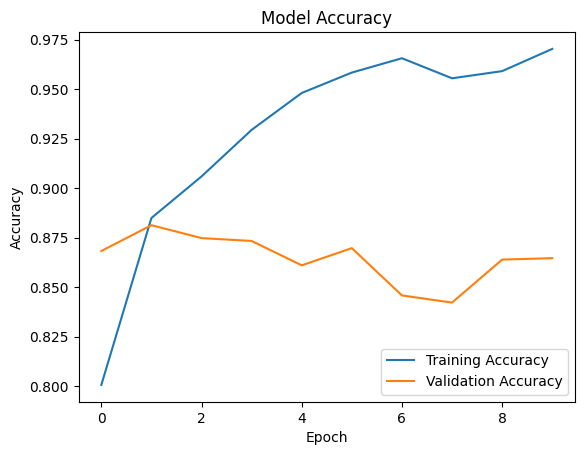

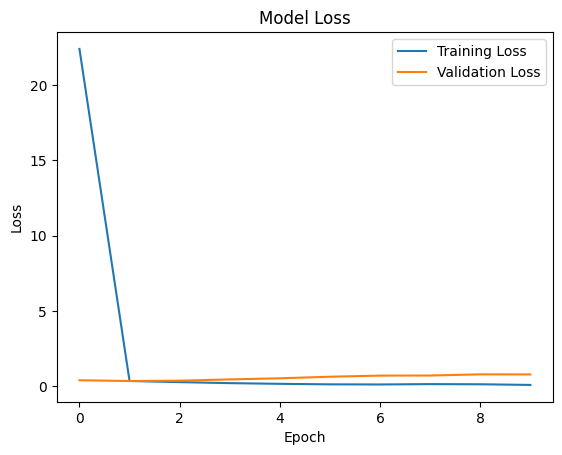

In [38]:
plt.plot(history_224['accuracy'], label='Training Accuracy')
plt.plot(history_224['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_224['loss'], label='Training Loss')
plt.plot(history_224['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [39]:
test_loss, test_accuracy = model_224.evaluate(test_224, batch_size=32)

68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.8729 - loss: 0.6305


So far, it seems that the larger images of size 224x224 pixels have yielded better training accuracies, but slightly worse validation and testing accuracies, showing significant signs of overfitting. Note, the total size of the 128x128 images is 60,000 while that of the 224x224 is only 9070, reduced to account for increased training time due to higher pixel count.

### ResNet-50

Brief Description:
- ResNet (Residual Network) is a convolutional neural network that democratized the concepts of residual learning and skip connections. This enables to train much deeper models.
- ResNet model pre-trained on ImageNet-1k at resolution 224x224.

In [23]:
#!{sys.executable} -m pip install transformers

In [24]:
# ResNet-50 requires PyTorch, so install that as well
#!{sys.executable} -m pip install torch torchvision

In [23]:
#!{sys.executable} -m pip install tf-keras

In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.models import Model

In [70]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [71]:
# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

In [72]:
# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

In [73]:
model_rn50 = Model(inputs=base_model.input, outputs=output)

In [74]:
model_rn50.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [75]:
model_rn50.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [76]:
history = model_rn50.fit(train_224, validation_data=val_224, epochs=10, batch_size=32)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.8112 - loss: 3.3925 - val_accuracy: 0.8747 - val_loss: 0.2852
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - accuracy: 0.9006 - loss: 0.2551 - val_accuracy: 0.8936 - val_loss: 0.2999
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.9267 - loss: 0.1846 - val_accuracy: 0.8885 - val_loss: 0.2727
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.9423 - loss: 0.1423 - val_accuracy: 0.9015 - val_loss: 0.3530
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.9444 - loss: 0.1390 - val_accuracy: 0.8972 - val_loss: 0.3668
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.9515 - loss: 0.1256 - val_accuracy: 0.9203 - val_loss: 0.2596
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - accuracy: 0.9624 - loss: 0.1072 - val_accuracy: 0.9175 - val_loss: 0.2901
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.9645 - loss: 0.1022 - val_accu

In [77]:
val_loss, val_accuracy = model_rn50.evaluate(val_224, batch_size=32)

44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9059 - loss: 0.3557


In [78]:
history_rn50 = history.history

In [79]:
history_rn50

{'accuracy': [0.811221718788147,
  0.9006335139274597,
  0.9266968369483948,
  0.9422624707221985,
  0.944434404373169,
  0.9514932036399841,
  0.9623529314994812,
  0.9645248651504517,
  0.9728506803512573,
  0.9697737693786621],
 'loss': [3.3925387859344482,
  0.25507035851478577,
  0.1845662146806717,
  0.14227865636348724,
  0.13904157280921936,
  0.12563209235668182,
  0.1072239801287651,
  0.10223773121833801,
  0.07054220885038376,
  0.07653719186782837],
 'val_accuracy': [0.8747284412384033,
  0.8935554027557373,
  0.8884866237640381,
  0.9015206098556519,
  0.8971759676933289,
  0.9203475713729858,
  0.9174511432647705,
  0.9188993573188782,
  0.9254163503646851,
  0.9058653116226196],
 'val_loss': [0.28523293137550354,
  0.29989728331565857,
  0.2727017104625702,
  0.35297778248786926,
  0.3668011426925659,
  0.2595836818218231,
  0.290107399225235,
  0.2655363082885742,
  0.3196113109588623,
  0.3557242155075073]}

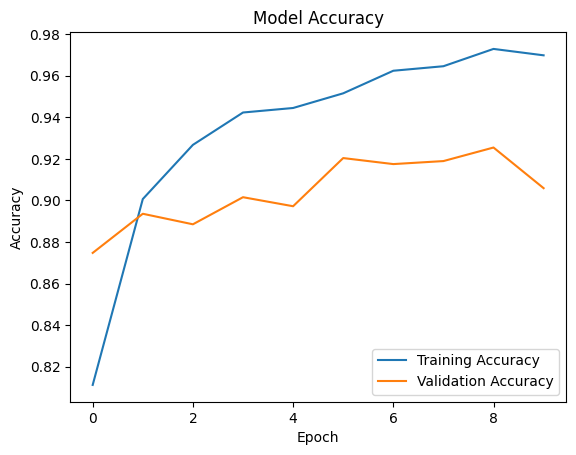

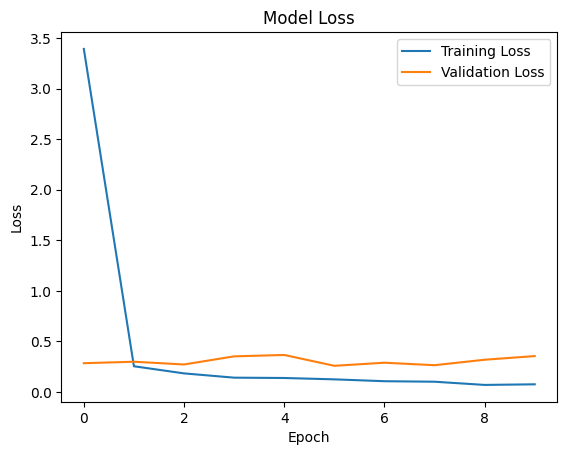

In [80]:
plt.plot(history_rn50['accuracy'], label='Training Accuracy')
plt.plot(history_rn50['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_rn50['loss'], label='Training Loss')
plt.plot(history_rn50['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [81]:
test_loss, test_accuracy = model_rn50.evaluate(test_224, batch_size=32)

68/68 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9090 - loss: 0.3518


### EfficientNetV2-B0

From: https://www.geeksforgeeks.org/computer-vision/efficientnet-architecture/

EfficientNet is a family of convolutional neural networks (CNNs) that aims to achieve high performance with fewer computational resources compared to previous architectures. It was introduced by Mingxing Tan and Quoc V. Le from Google Research in their 2019 paper "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks." The core idea behind EfficientNet is a new scaling method that uniformly scales all dimensions of depth, width, and resolution using a compound coefficient.

In [24]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D

In [23]:
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [25]:
# Like with ResNet, freeze the base layers
base_model.trainable = False

In [26]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [27]:
model_en_b0 = Model(inputs=base_model.input, outputs=output)

In [28]:
model_en_b0.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [29]:
model_en_b0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 56, 56, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 56, 56, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 56, 56, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 56, 56, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 56, 56, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2b_expand_conv (Conv2D)  │ (None, 56, 56, 128)       │          36,86

 Total params: 6,083,409 (23.21 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [30]:
history = model_en_b0.fit(train_224, validation_data=val_224, epochs=10, batch_size=32)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.8063 - loss: 0.4164 - val_accuracy: 0.8624 - val_loss: 0.3145
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8563 - loss: 0.3306 - val_accuracy: 0.8849 - val_loss: 0.2777
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8778 - loss: 0.2889 - val_accuracy: 0.8885 - val_loss: 0.2674
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8892 - loss: 0.2684 - val_accuracy: 0.8957 - val_loss: 0.2506
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8992 - loss: 0.2402 - val_accuracy: 0.8993 - val_loss: 0.2406
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9111 - loss: 0.2204 - val_accuracy: 0.9001 - val_loss: 0.2407
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9209 - loss: 0.2033 - val_accuracy: 0.8928 - val_loss: 0.2469
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9216 - loss: 0.1920 - val_accu

In [31]:
val_loss, val_accuracy = model_en_b0.evaluate(val_224, batch_size=32)

44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 931ms/step - accuracy: 0.8979 - loss: 0.2289


In [32]:
history_en_b0 = history.history

In [33]:
history_en_b0

{'accuracy': [0.8063348531723022,
  0.8562895655632019,
  0.877828061580658,
  0.8892307877540588,
  0.8991855382919312,
  0.9111312031745911,
  0.9209049940109253,
  0.9216289520263672,
  0.9277828335762024,
  0.9342986345291138],
 'loss': [0.4164034128189087,
  0.33060720562934875,
  0.2889135181903839,
  0.2684345543384552,
  0.24017849564552307,
  0.22042731940746307,
  0.20329861342906952,
  0.19199152290821075,
  0.17941638827323914,
  0.16687047481536865],
 'val_accuracy': [0.862418532371521,
  0.8848660588264465,
  0.8884866237640381,
  0.8957277536392212,
  0.8993483185768127,
  0.9000723958015442,
  0.8928312659263611,
  0.8993483185768127,
  0.8971759676933289,
  0.8979000449180603],
 'val_loss': [0.314511239528656,
  0.2776990830898285,
  0.2674301266670227,
  0.25059640407562256,
  0.24056310951709747,
  0.240667924284935,
  0.246916264295578,
  0.23583413660526276,
  0.2369598001241684,
  0.22890934348106384]}

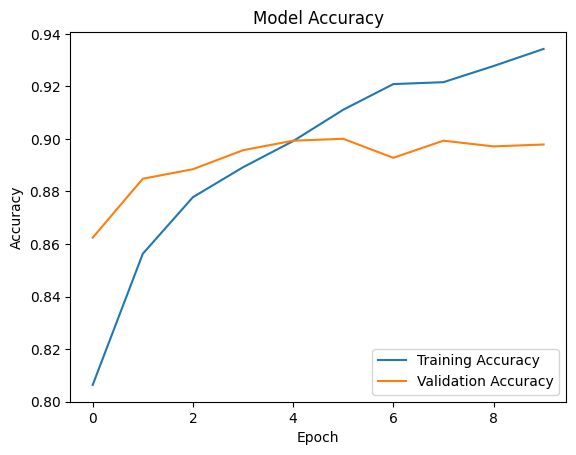

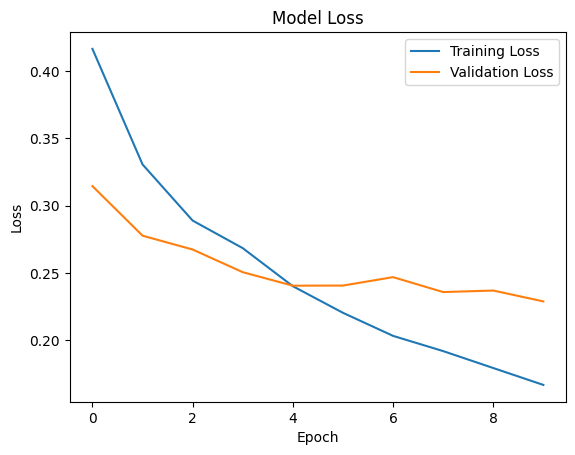

In [34]:
plt.plot(history_en_b0['accuracy'], label='Training Accuracy')
plt.plot(history_en_b0['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_en_b0['loss'], label='Training Loss')
plt.plot(history_en_b0['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [35]:
test_loss, test_accuracy = model_en_b0.evaluate(test_224, batch_size=32)

68/68 ━━━━━━━━━━━━━━━━━━━━ 64s 941ms/step - accuracy: 0.9094 - loss: 0.2141


EfficientNet was notably faster than ResNet but has a slight decrease in accuracy, though this trade off may be worth the price as the accuracy decrease was about 2% while the training time was shrunk by more than half.

### ConvNeXt Base

A successor to ResNet in the form a large vision model (LVM) while maintaining the CNN structure. The model were first pre-trained on the ImageNet-21k dataset and then fine-tuned on the ImageNet-1k dataset.

In [22]:
#!{sys.executable} -m pip install keras_hub

In [28]:
#!{sys.executable} -m pip install -U tensorflow-text==2.19.0

In [25]:
import keras_hub

C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
from tensorflow.keras.applications import ConvNeXtBase

In [27]:
base_model = ConvNeXtBase(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [33]:
base_model.trainable = False

In [34]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

In [35]:
model_cnb = Model(inputs=base_model.input, outputs=output)

In [37]:
model_cnb.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [38]:
model_cnb.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_prestem_normal… │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stem            │ (None, 56, 56, 128)       │           6,528 │ convnext_base_prestem_nor… │
│ (Sequential)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stage_0_block_… │ (None, 56, 56, 128)       │           6,400 │ convnext_base_stem[0][0]   │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stage_0_block_… │ (None, 56, 56, 128)       │             256 │ convnext_base_stage_0_blo… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stage_0_block_… │ (None, 56, 56, 512)       │          66,048 │ convnext_base_stage_0_blo… │
│ (Dense)                       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stage_0_block_… │ (None, 56, 56, 512)       │               0 │ convnext_base_stage_0_blo… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stage_0_block_… │ (None, 56, 56, 128)       │          65,664 │ convnext_base_stage_0_blo… │
│ (Dense)                       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stage_0_block_… │ (None, 56, 56, 128)       │             128 │ convnext_base_stage_0_blo… │
│ (LayerScale)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stage_0_block_… │ (None, 56, 56, 128)       │               0 │ convnext_base_stage_0_blo… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 56, 56, 128)       │               0 │ convnext_base_stem[0][0],  │
│                               │                           │                 │ convnext_base_stage_0_blo… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_base_stage_0_block_… │ (None, 56, 56, 128)       │           6,400 │ add[0][0]                  │
│ (Conv2D)                      │                           │               

 Total params: 87,829,121 (335.04 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [40]:
history = model_cnb.fit(train_224, validation_data=val_224, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5309s 30s/step - accuracy: 0.8717 - loss: 0.2876 - val_accuracy: 0.9203 - val_loss: 0.1977
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4862s 28s/step - accuracy: 0.9173 - loss: 0.2086 - val_accuracy: 0.9254 - val_loss: 0.1786
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 11696s 68s/step - accuracy: 0.9252 - loss: 0.1790 - val_accuracy: 0.9305 - val_loss: 0.1732
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4748s 27s/step - accuracy: 0.9356 - loss: 0.1606 - val_accuracy: 0.9232 - val_loss: 0.1848
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4784s 28s/step - accuracy: 0.9388 - loss: 0.1500 - val_accuracy: 0.9305 - val_loss: 0.1625
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4848s 28s/step - accuracy: 0.9443 - loss: 0.1404 - val_accuracy: 0.9276 - val_loss: 0.1763
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4855s 28s/step - accuracy: 0.9520 - loss: 0.1198 - val_accuracy: 0.9269 - val_loss: 0.1802
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4872s 28s/step - accuracy: 0.9567 - loss: 

In [41]:
val_loss, val_accuracy = model_cnb.evaluate(val_224, batch_size=32)

44/44 ━━━━━━━━━━━━━━━━━━━━ 568s 13s/step - accuracy: 0.9276 - loss: 0.1800


In [42]:
history_cnb = history.history

In [43]:
history_cnb

{'accuracy': [0.8716741800308228,
  0.9172850847244263,
  0.9252488613128662,
  0.9355655908584595,
  0.9388235211372375,
  0.9442533850669861,
  0.9520362019538879,
  0.9567421078681946,
  0.9585520625114441,
  0.9618099331855774],
 'loss': [0.2876023054122925,
  0.20856492221355438,
  0.17895469069480896,
  0.1605539321899414,
  0.14997845888137817,
  0.14041565358638763,
  0.11977285891771317,
  0.1154475286602974,
  0.10540740191936493,
  0.09931538254022598],
 'val_accuracy': [0.9203475713729858,
  0.9254163503646851,
  0.9304851293563843,
  0.9232439994812012,
  0.9304851293563843,
  0.927588701248169,
  0.9268645644187927,
  0.9370021820068359,
  0.9312092661857605,
  0.927588701248169],
 'val_loss': [0.19772394001483917,
  0.1786121129989624,
  0.173233300447464,
  0.18478532135486603,
  0.16254623234272003,
  0.17632709443569183,
  0.18015842139720917,
  0.16700011491775513,
  0.16940626502037048,
  0.18002627789974213]}

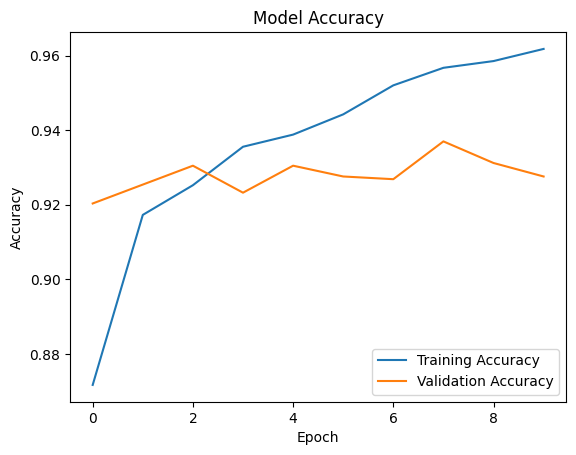

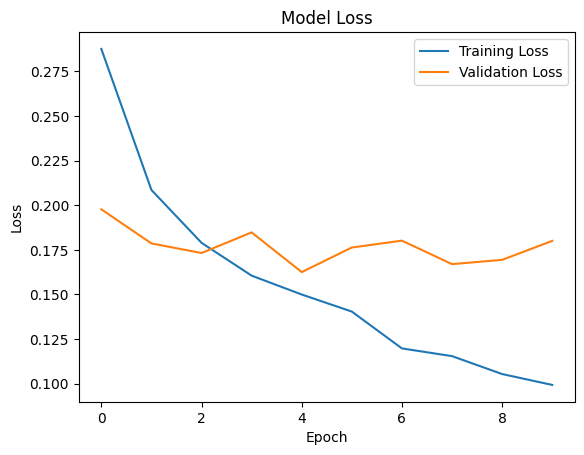

In [44]:
plt.plot(history_cnb['accuracy'], label='Training Accuracy')
plt.plot(history_cnb['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_cnb['loss'], label='Training Loss')
plt.plot(history_cnb['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [45]:
test_loss, test_accuracy = model_cnb.evaluate(test_224, batch_size=32)

68/68 ━━━━━━━━━━━━━━━━━━━━ 886s 13s/step - accuracy: 0.9404 - loss: 0.1569


Compared to previous models, the large vision model clearly performed much better in terms of accuracy and having a relatively low degree of overfitting. Unfortunately, the cost of this was at least 10 times the training time needed compared to next longest model (ResNet). Thus, this model should only be considered if the device running this has sufficiently powerful GPUs to dramatically reduce the training time.

### Summary of Models

In [50]:
tr_accuracy_128 = [0.8542, 0.8882, 0.8971, 0.9004, 0.9049, 0.9105, 0.9116, 0.9138, 0.9181, 0.9218]
tr_time_128 = [519, 334, 329, 400, 324, 413, 360, 333, 324, 326]
te_accuracy_128 = 0.9044

In [51]:
tr_accuracy_224 = [0.8005, 0.8849, 0.9059, 0.9294, 0.9481, 0.9584, 0.9656, 0.9555, 0.9591, 0.9703]
tr_time_224 = [191, 177, 178, 178, 176, 177, 176, 173, 172, 172]
te_accuracy_224 = 0.8729

In [52]:
tr_accuracy_rn50 = [0.8042, 0.8838, 0.9126, 0.9332, 0.9365, 0.9473, 0.9549, 0.9613, 0.9643, 0.9586]
tr_time_rn50 = [527, 507, 516, 517, 520, 519, 517, 525, 529, 530]
te_accuracy_rn50 = 0.9205

In [53]:
tr_accuracy_en_b0 = [0.8063, 0.8563, 0.8778, 0.8892, 0.8992, 0.9111, 0.9209, 0.9216, 0.9278, 0.9343]
tr_time_en_b0 = [234, 199, 203, 205, 204, 202, 201, 200, 202, 202]
te_accuracy_en_b0 = 0.9094

In [54]:
tr_accuracy_cnb = [0.8717, 0.9173, 0.9252, 0.9356, 0.9388, 0.9443, 0.9520, 0.9567, 0.9586, 0.9618]
tr_time_cnb = [5309, 4862, 5848, 4748, 4784, 4848, 4855, 4872, 4635, 2802]
te_accuracy_cnb = 0.9404

In [64]:
print("Model average and standard deviation of training accuracies")
print("CNN 128:\t\t", np.mean(tr_accuracy_128), "\t", np.std(tr_accuracy_128))
print("CNN 224:\t\t", np.mean(tr_accuracy_224), "\t", np.std(tr_accuracy_224))
print("ResNet-50:\t\t", np.mean(tr_accuracy_rn50), "\t", np.std(tr_accuracy_rn50))
print("EfficientNet:\t\t", np.mean(tr_accuracy_en_b0), "\t", np.std(tr_accuracy_en_b0))
print("Large Vision Model:\t", np.mean(tr_accuracy_cnb), "\t", np.std(tr_accuracy_cnb))

Model average and standard deviation of training accuracies
CNN 128:		 0.90206 	 0.018614843539498258
CNN 224:		 0.92777 	 0.049858179870508716
ResNet-50:		 0.92567 	 0.04692683773705618
EfficientNet:		 0.89445 	 0.03737296482753275
Large Vision Model:	 0.9362 	 0.025569904184411785


In [66]:
print("Model average and standard deviation of training times")
print("CNN 128:\t\t", np.mean(tr_time_128), "\t\t", np.std(tr_time_128))
print("CNN 224:\t\t", np.mean(tr_time_224), "\t\t", np.std(tr_time_224))
print("ResNet-50:\t\t", np.mean(tr_time_rn50), "\t\t", np.std(tr_time_rn50))
print("EfficientNet:\t\t", np.mean(tr_time_en_b0), "\t\t", np.std(tr_time_en_b0))
print("Large Vision Model:\t", np.mean(tr_time_cnb), "\t", np.std(tr_time_cnb))

Model average and standard deviation of training times
CNN 128:		 366.2 		 59.51436801311092
CNN 224:		 177.0 		 5.157518783291051
ResNet-50:		 520.7 		 6.738694235532579
EfficientNet:		 205.2 		 9.744742172063866
Large Vision Model:	 4756.3 	 733.1326005573616


In [67]:
print("Model testing accuracies")
print("CNN 128:\t\t", te_accuracy_128)
print("CNN 224:\t\t", te_accuracy_224)
print("ResNet-50:\t\t", te_accuracy_rn50)
print("EfficientNet:\t\t", te_accuracy_en_b0)
print("Large Vision Model:\t", te_accuracy_cnb)

Model testing accuracies
CNN 128:		 0.9044
CNN 224:		 0.8729
ResNet-50:		 0.9205
EfficientNet:		 0.9094
Large Vision Model:	 0.9404


### Conclusion

The large vision model is the most accurate but by far requires the greatest computing power, thus the model best optimized for lower end devices would be ResNet-50, with decent accuracy as well as acceptable runtime for training. These 2 models will be selected for saving.

### Save the Models

In [83]:
import datetime

In [68]:
from library.sb_utils import save_file

In [84]:
# ResNet-50 Model
model_1 = model_rn50
model_1.version = 1.0
model_1.pandas_version = pd.__version__
model_1.numpy_version = np.__version__
model_1.tensorflow_version = tf.__version__
model_1.keras_version = tf.keras.__version__
model_1.build_datetime = datetime.datetime.now()

In [85]:
modelpath = 'models'
save_file(model_1, 'image_classifier_model_resnet_50.pkl', modelpath)

Directory models was created.
Writing file.  "models\image_classifier_model_resnet_50.pkl"


In [86]:
# Large Vision Model
model_2 = model_cnb
model_2.version = 1.0
model_2.pandas_version = pd.__version__
model_2.numpy_version = np.__version__
model_2.tensorflow_version = tf.__version__
model_2.keras_version = tf.keras.__version__
model_2.build_datetime = datetime.datetime.now()

In [88]:
modelpath = 'models'
save_file(model_2, 'image_classifier_model_conv_next_base.pkl', modelpath)

Writing file.  "models\image_classifier_model_conv_next_base.pkl"
